<a href="https://colab.research.google.com/github/st3107/20210818_iucr_diffpy_talk/blob/main/notebooks/03_example_script_for_colab_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare the conda environment

## Install the mini-conda and use it to install diffpy-cmi

In [ ]:
!echo $PYTHONPATH

/env/python


In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-latest-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... done

# All requested packages already installed.

installation finished.


--2021-08-10 23:39:00--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-08-10 23:39:00--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66709754 (64M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh.3’

     0K .......... .......... .......... .......... ..........  0% 4.65M 14s
    50K .......... .......... .......... .......... .......

In [ ]:
!which conda

/usr/local/bin/conda


In [ ]:
!conda --version

conda 4.10.3


In [ ]:
!conda create -n diffpy -c defaults -c diffpy python=3.7 diffpy-cmi pandas --yes

Solving environment: - \ | / - \ | / - failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local/envs/diffpy

  added / updated specs:
    - diffpy-cmi
    - pandas
    - python=3.7


The following NEW packages will be INSTALLED:

  _libgcc_mutex      pkgs/main/linux-64::_libgcc_mutex-0.1-main
  _openmp_mutex      pkgs/main/linux-64::_openmp_mutex-4.5-1_gnu
  argon2-cffi        pkgs/main/linux-64::argon2-cffi-20.1.0-py37h27cfd23_1
  async_generator    pkgs/main/linux-64::async_generator-1.10-py37h28b3542_0
  attrs              pkgs/main/noarch::attrs-21.2.0-pyhd3eb1b0_0
  backcall

In [ ]:
!conda env list

# conda environments:
#
base                  *  /usr/local
diffpy                   /usr/local/envs/diffpy



## Configure the python to recognize the diffpy library

In [ ]:
!ls /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy*

/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.srfit.pth
/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.structure.pth
/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.utils.pth

/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy:
__init__.py  __pycache__  srreal

/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg:
diffpy	EGG-INFO

/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.srreal-1.3.0-py3.7-linux-x86_64.egg-info:
dependency_links.txt  not-zip-safe  requires.txt  top_level.txt
native_libs.txt       PKG-INFO	    SOURCES.txt

/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.structure-3.0.1-py3.7.egg:
diffpy	EGG-INFO

/usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.utils-3.0.0-py3.7.egg:
diffpy	EGG-INFO


In [ ]:
!cp -r /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.srfit-3.0.0-py3.7.egg/diffpy/* /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy/

In [ ]:
!cp -r /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.structure-3.0.1-py3.7.egg/diffpy/* /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy/

In [ ]:
!cp -r /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy.utils-3.0.0-py3.7.egg/diffpy/* /usr/local/envs/diffpy/lib/python3.7/site-packages/diffpy/

In [ ]:
import sys

In [ ]:
sys.path.insert(1, "/usr/local/envs/diffpy/lib/python3.7/site-packages")

## Test if we can import diffpy

In [ ]:
import diffpy.srfit
import diffpy.srreal
import diffpy.structure
import diffpy.utils

## Download the example data from github

In [ ]:
!git clone https://github.com/st3107/20210818_iucr_diffpy_talk.git

fatal: destination path '20210818_iucr_diffpy_talk' already exists and is not an empty directory.


In [ ]:
!cp -r ./20210818_iucr_diffpy_talk/notebooks/colab_data ./data

In [ ]:
!ls ./data

bronze				      pdfitc_search_residuals.csv
bronze_anatase			      pdfitc_search_results_data.csv
bronze_anatase_ligand		      tem.png
bronze_anatase_ligand_50A	      TiO2_anatase.cif
bronze_anatase_ligand_50A_coreshell   TiO2_bronze.cif
bronze_anatase_ligand_50A_lognormal   TiO2_np_ligand.gr
bronze_anatase_ligand_50A_spheroidal  TiO2_residuals.gr
colab_data


# Customized PDF fitting based on the APIs in diffpy-cmi

In this notebook, we will show an example how to use the APIs in the diffpy-cmi to create your own tools of PDF fitting.

In [ ]:
%matplotlib inline

## Import the modules

Below are modules we used to create our tools. We also define a variable "F" which contains a collection of predefined characteristic functions from diffpy-cmi that we will use later.

In [ ]:
import typing
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from scipy.optimize import least_squares
from diffpy.utils.parsers.loaddata import loadData
from diffpy.srfit.fitbase import FitRecipe, FitContribution, Profile, FitResults
from diffpy.srfit.pdf import PDFGenerator, PDFParser
from diffpy.srfit.fitbase.parameterset import ParameterSet
from pyobjcryst import loadCrystal
from pyobjcryst.crystal import Crystal
import diffpy.srfit.pdf.characteristicfunctions

F = diffpy.srfit.pdf.characteristicfunctions

## Introduction to the basic classes in diffpy-cmi

### Profile

The `Profile` is an object to hold data and metadata. For example, in this example we have a simulated dataset that is a linear line with noise.

`Profile` is a general container for any profile.  We make a particular instance of it called `noisy_linear` that contains our particular profile.

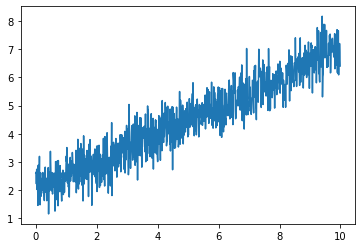

In [ ]:
x = np.arange(0., 10, 0.01)
y = 0.5 * x + 2.0 + np.random.normal(scale=0.5, size=x.shape[0])
noisy_linear = Profile()
noisy_linear.setObservedProfile(x, y)
plt.plot(noisy_linear.x, noisy_linear.y)

### FitContribution

Now we want to fit something to our profile.  We use a `FitContribution` object to hold all the info about each contribution in the fit (e.g., a phase in a multi-phase fit and the model to fit to it).  So we create a particular instance of `FitContribution` for this noisy linear data and give it a short and memorable name, `nlc`.  Diffpy-cmi also allows you to give this a name attribute that we set to `noisy_linear`.  Then we give it our `noisy_linear` `Profile`.  

In [ ]:
nlc = FitContribution("noisy_linear")
nlc.setProfile(noisy_linear)

`nlc` should also contain the model to fit to the data. The model can be defined by a string equation. For example, our data is a straight line, we may want to use "a * x + b" as the model. Here, the "a", "b" are two scalar parameters and "x" is a the independent variable, this is the most direct way to use diffpy-cmi.

In [ ]:
nlc.setEquation("a * x + b")

### FitRecipe

In general, a fit may contain multiple components (multiple phases, etc. but also the constraints and variables that affect th fit).  The object to contain the complex fit is the `FitRecipe` and we need to create a particular instance of this for our (single component) linear fit.  Let's call it `nlr` for noisy-linear-recipe.  After instantiating it, we add our contribution.

In [ ]:
nlr = FitRecipe()
nlr.addContribution(nlc)

After it is added, the `FitContribution` will be an attribute of `FitRecipe` and user can access it.

In [ ]:
nlr.noisy_linear

There is a default `FitHook` for printing which is not always useful. We will clear it for this tutorial.

In [ ]:
nlr.fithooks.clear()

We can add the parameters from the model in the `FitContribution` into the `FitRecipe` as variables to vary in the fit.

In [ ]:
nlr.addVar(nlc.a)
nlr.addVar(nlc.b)

After it is added, we can set an initial value for it.

In [ ]:
nlr.a.setValue(1.)
nlr.b.setValue(1.)

### Optimization

The `FitRecipe` is not in charge of the optimization of parameters. It is only a interface to manage parameters and generate the residual. We need to use optimization tools outside the diffpy-cmi, for example `scipy.optimize.least_squares` that was imported above with its name shortened to `least_squares`.  To run it needs the computed residual (sum of squares of difference between the model and the data in this case) and the variables that it will vary, which are returned by the `getValues()` method in `FitRecipe`.  After it runs it will update the values to new, refined, values which are the result of the fit.

In [ ]:
least_squares(nlr.residual, nlr.getValues(), verbose=1);

`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 2.2808e+03, final cost 1.3080e+02, first-order optimality 2.42e-07.


Now, we successfully used the diffpy-cmi to do a linear regression.  We can do things like plot the results and output a table of the refined parameters

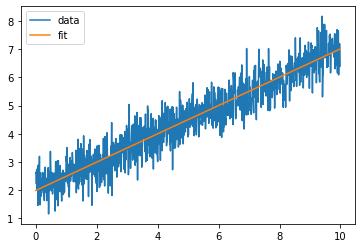

In [ ]:
plt.plot(noisy_linear.x, noisy_linear.y, label="data")
plt.plot(noisy_linear.x, noisy_linear.ycalc, label="fit")
plt.legend()

In [ ]:
nlr.show()

Parameters
------------------------------------------------------------------------------
a   0.5025983968533896
b   1.9884326984407146

noisy_linear.x      [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.
noisy_linear.y      [2.60103094 2.63828134 2.22102181 2.73969478 2.02383443 2.
noisy_linear.dy     [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 
noisy_linear.a      0.5025983968533896
noisy_linear.b      1.9884326984407146


### Use python function in the equation

What if we cannot write out the equation using the a simple hand-written function? For example, our data is a stretched and scaled zero order Bessel function.

In [ ]:
import scipy.special as special

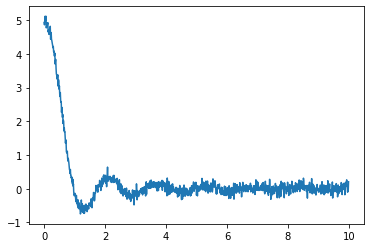

In [ ]:
x = np.arange(0., 10, 0.01)
y = 10 * special.besselpoly(x / 0.5, 1, 0) + np.random.normal(scale=0.1, size=x.shape[0])
noisy_bessel = Profile()
noisy_bessel.setObservedProfile(x, y)
plt.plot(noisy_bessel.x, noisy_bessel.y)

In [ ]:
nbc = FitContribution("noisy_bessel")
nbc.setProfile(noisy_bessel)

In this case, we need to define a Bessel function and register it in the equation using `registerFunction`. Here, the equation "f" is not a scalar parameter "f" but a symbol representing the registered function so the actual model is "y = bessel(x, a, b)"

In [ ]:
def bessel(x, a, b):
    return a * special.besselpoly(x / b, 1, 0)

In [ ]:
nbc.registerFunction(bessel, name="f")
nbc.setEquation("f")

In [ ]:
nbr = FitRecipe()
nbr.clearFitHooks()
nbr.addContribution(nbc)
nbr.addVar(nbc.a)
nbr.addVar(nbc.b)
nbr.a.setValue(0.5)
nbr.b.setValue(0.5)

In [ ]:
least_squares(nbr.residual, nbr.getValues(), verbose=1);

`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 4.8729e+02, final cost 5.2195e+00, first-order optimality 1.11e+06.


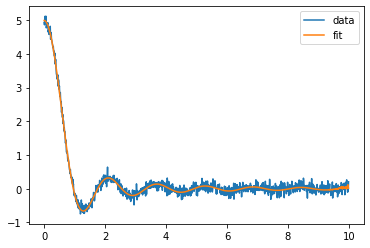

In [ ]:
plt.plot(noisy_bessel.x, noisy_bessel.y, label="data")
plt.plot(noisy_bessel.x, noisy_bessel.ycalc, label="fit")
plt.legend()

In [ ]:
nbr.show()

Parameters
------------------------------------------------------------------------------
a   9.977478595253306
b   0.4999995803675697

noisy_bessel.x      [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.
noisy_bessel.y      [ 4.92992730e+00  4.86040263e+00  4.98504852e+00  5.113313
noisy_bessel.dy     [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 
noisy_bessel.a      9.977478595253306
noisy_bessel.b      0.4999995803675697


### Use PDFGenerator in the equation

Now, what if our data is a PDF data? Our model will include structures with parameters like lattice constants and ADPs. We can define our python function for the calculation of the PDF and add it to `FitContribution`. However, every time there is a new structure, we need to define a function and this is inefficient. We would like a python class that loads a structure inside, calculates PDF when called and contains the parameters of the structure in its attributes.

diffpy-cmi can also accept the python class but it must be the child class of the `ProfileGenerator`. Usually, users don't need to define it because diffpy-cmi provides the predefined `PDFGenerator` for the users, but if you wanted to add a new profile generator, like for a Raman or NMR spectrum, this is how you would do it. For this example of just PDF we just need to use `addProfileGenerator` to add it in the `FitContribution`.

In [ ]:
crystal = loadCrystal("./data/TiO2_bronze.cif")
pg = PDFGenerator("TiO2")
pg.setStructure(crystal, periodic=True)

In [ ]:
fc = FitContribution("PDF")
fc.addProfileGenerator(pg)
fc.setEquation("TiO2")

After it is added, it is an attribute of `FitContribution`.

In [ ]:
fc.TiO2

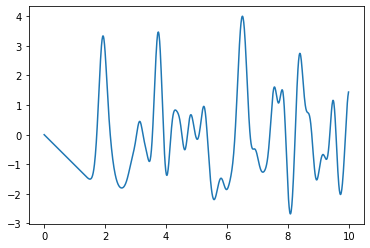

In [ ]:
x = np.arange(0., 10., 0.01)
y = fc.TiO2(x)
plt.plot(x, y)

### diffpy-cmi = modeling interface + PDF library

In a nutshell, diffpy-cmi is a modeling interface together with a library of PDF calculators and characteristic functions. The interface for users to manage the variables and the calculators are separated. Users need to combine them when using the diffpy-cmi. This seems to produce a bit more work but it gives opportunities to developers in the open source world to further develop diffpy-cmi to do more and more things. They can add new calculators in the library keeping the interface untouched, use the calculators in another place or develop their own interface based on diffpy-cmi.  They can also build gui's and other user-interfaces to hide some of this complexity from non-programmer users!

In the next section, we will show a simple example how to use diffpy-cmi to fit the PDF.

## Fit the data of TiO2 nanoparticles with TiO2 bronze phase

In this section, we will create tools and use them in the fitting of the data from the TiO2 nanoparticles.

## The data file of G(r)

In [ ]:
GR_FILE = "./data/TiO2_np_ligand.gr"

To create a FitRecipe, we need data and a model. The data is a two column file where the first column is the value of distance `r` and the second column is the value of PDF `G`. The file may also contain the headers where the metadata is written in the "key = value" format. Below shows the first several rows of the data file that we will use in the fitting that was obtiained from the `PDFgetX3` program.

In [ ]:
!head -40 "./data/TiO2_np_ligand.gr"

# xPDFsuite Configuration #
[PDF]
wavelength = 0.1
dataformat = Qnm
inputfile = JBNP33L_20180812-162201_05b4b9_0001.chi
backgroundfile = kapton_Jon_20180812-170509_77fbc8_0001.chi
mode = xray
bgscale = 1.0
composition = TiO2
outputtype = gr
qmaxinst = 24.0
qmin = 0.1
qmax = 22.0
rmax = 100.0
rmin = 0.0
rstep = 0.01
rpoly = 0.9

[Misc]
inputdir = /home/soham/Documents/CurrentClean/DeRoo_titaniaZirconia/collateChi
savedir = /home/soham/Documents/CurrentClean/DeRoo_titaniaZirconia/collateChi/gr_22
backgroundfilefull = /home/soham/Documents/CurrentClean/DeRoo_titaniaZirconia/collateChi/kapton_Jon_20180812-170509_77fbc8_0001.chi

#### start data
#S 1
#L r($\AA$)  G($\AA^{-2}$)
0 0
0.01 -0.00457916
0.02 -0.00891683
0.03 -0.0127965
0.04 -0.0160245
0.05 -0.0184399
0.06 -0.019922
0.07 -0.0203965
0.08 -0.0198392
0.09 -0.018277
0.1 -0.0157869
0.11 -0.0124922
0.12 -0.00855612
0.13 -0.00417451


### Initial guess of the structure

By uploading the file to the structureMining App in the [PDFitc](https://pdfitc.org/) website we can automatically get good starting models to save us some time. The result is sorted from the best to the worst in the table. We find the best candidate to start with is the bronze phase structure (space group "C2/m") in the Materials Project Database.

In [ ]:
DATA_MINING_FILE = "./data/pdfitc_search_results_data.csv"

In [ ]:
import pandas as pd

df = pd.read_csv(DATA_MINING_FILE, index_col=0)
df[["rw", "formula", "space_group", "db", "db_id"]].head(10)

,rw,formula,space_group,db,db_id
0,0.385756,TiO2,C2/m,MPD,mp-554278
1,0.782432,TiO2,I4/m,MPD,mp-1101022
2,0.851652,TiO2,C2/m,COD,1528778
3,0.852381,TiO2,P1,MPD,mp-1245308
4,0.869716,TiO2,I4_1/amd,COD,7206075
5,0.870515,TiO2,I4_1/amd,COD,1526931
6,0.873701,TiO2,I4_1/amd,COD,9008213
7,0.873790,TiO2,I4_1/amd,COD,9015929
8,0.874338,TiO2,I4_1/amd,COD,9008214
9,0.874753,TiO2,I4_1/amd,COD,9008215


We download the cif file from the database and put it to the place shown below.

In [ ]:
CIF_FILE_B = "./data/TiO2_bronze.cif"

### Create our first FitRecipe

In this section, we will create our first FitRecipe. A FitRecipe is the interface that user to interact with in the fitting. It contains FitContribution, which is a fit of anything. Here, we will make a helper function `create_recipe_from_files` that creates a single-FitContribution and FitRecipe from the data and structure files in one step. We can reuse this function so do fits many times over with little typing.  This step is not required, but it makes things easier, and these helper functions can be shared to speed things up for everyone.

In [ ]:
def _create_recipe(
        equation: str,
        crystals: typing.Dict[str, Crystal],
        functions: typing.Dict[str, typing.Tuple[typing.Callable, typing.List[str]]],
        profile: Profile,
        fc_name: str = "PDF"
) -> FitRecipe:
    """Create the FitRecipe object.

    Parameters
    ----------
    equation :
        The equation of G(r).
    crystals :
        A mapping from the name of variable in the equation to the crystal structure for PDF calculation.
    functions :
        A mapping from the name of variable in the equation to the python function for PDF calculation.
        The first argument of the function is the array of r, the other arguments are the parameters.
    profile :
        The data profile that contains both the metadata and the data.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".

    Returns
    -------
    A FitRecipe object.
    """
    fr = FitRecipe()
    fc = FitContribution(fc_name)
    for name, crystal in crystals.items():
        pg = PDFGenerator(name)
        pg.setStructure(crystal, periodic=True)
        fc.addProfileGenerator(pg)
    for name, (f, argnames) in functions.items():
        fc.registerFunction(f, name=name, argnames=argnames)
    fc.setEquation(equation)
    fc.setProfile(profile, xname="r", yname="G", dyname="dG")
    fr.addContribution(fc)
    return fr


def _get_tags(phase: str, param: str) -> typing.List[str]:
    """Get the tag names.

    Parameters
    ----------
    phase
    param

    Returns
    -------

    """
    return [param, phase, "{}_{}".format(phase, param)]


def _get_name(*args: str) -> str:
    """Get the name of the variable.

    Parameters
    ----------
    args

    Returns
    -------

    """
    return "_".join(args)


def _rename_par(name: str, atoms: list) -> str:
    """Rename of the name of a parameter by replacing the index of the atom in the name by the label of
    the atom and revert the order of coordinates and atom name.

    Used for the space group constrained parameters. For example, "x_0" where atom index 0 is Ni will become
    "Ni0_x" after renamed. If the name can not renamed, return the original name.

    Parameters
    ----------
    name
    atoms

    Returns
    -------

    """
    parts = name.split("_")
    np = len(parts)
    na = len(atoms)
    if np > 1 and parts[1].isdigit() and -1 < int(parts[1]) < na:
        parts[1] = atoms[int(parts[1])].name
        parts = parts[::-1]
    return "_".join(parts)


def _add_params_in_pg(recipe: FitRecipe, pg: PDFGenerator) -> None:
    """Add parameters in the PDFGenerator.

    Parameters
    ----------
    recipe
    pg

    Returns
    -------

    """
    name: str = pg.name
    recipe.addVar(
        pg.scale,
        name=_get_name(name, "scale"),
        value=0.,
        fixed=True,
        tags=_get_tags(name, "scale")
    ).boundRange(0.)
    recipe.addVar(
        pg.delta2,
        name=_get_name(name, "delta2"),
        value=0.,
        fixed=True,
        tags=_get_tags(name, "delta2")
    ).boundRange(0.)
    latpars = pg.phase.sgpars.latpars
    for par in latpars:
        recipe.addVar(
            par,
            name=_get_name(name, par.name),
            fixed=True,
            tags=_get_tags(name, "lat")
        ).boundRange(0.)
    atoms: typing.List[ParameterSet] = pg.phase.getScatterers()
    for atom in atoms:
        par = atom.Biso
        recipe.addVar(
            par,
            name=_get_name(name, atom.name, "Biso"),
            value=0.02,
            fixed=True,
            tags=_get_tags(name, "adp")
        ).boundRange(0.)
    xyzpars = pg.phase.sgpars.xyzpars
    for par in xyzpars:
        par_name = _rename_par(par.name, atoms)
        recipe.addVar(
            par,
            name=_get_name(name, par_name),
            fixed=True,
            tags=_get_tags(name, "xyz")
        )
    return


def _add_params_in_fc(
        recipe: FitRecipe,
        fc: FitContribution,
        names: typing.List[str],
        tags: typing.List[str]
) -> None:
    """Add parameters in the FitContribution.

    Parameters
    ----------
    recipe
    fc
    names
    tags

    Returns
    -------

    """
    for name in names:
        par = getattr(fc, name)
        recipe.addVar(
            par,
            value=100.,
            fixed=True,
            tags=tags
        )
    return


def _initialize_recipe(
        recipe: FitRecipe,
        functions: typing.Dict[str, typing.Tuple[typing.Callable, typing.List[str]]],
        crystals: typing.Dict[str, Crystal],
        fc_name: str = "PDF"
) -> None:
    """Initialize the FitRecipe object with variables.

    The parameters are the scale of the PDF, the delta2 parameter in the correction of correlated motions,
    the atomic displacement parameters (ADPs) of the symmetric unique atoms, the x, y, z positions of the
    symmetric unique atoms under the constraint of the symmetry and the parameters in the functions registered
    in the FitContribution.

    Parameters
    ----------
    recipe
    functions
    crystals
    fc_name

    Returns
    -------

    """
    fc: FitContribution = getattr(recipe, fc_name)
    for name, (_, argnames) in functions.items():
        _add_params_in_fc(recipe, fc, argnames[1:], tags=[name])
    for name in crystals.keys():
        pg: PDFGenerator = getattr(fc, name)
        _add_params_in_pg(recipe, pg)
    recipe.clearFitHooks()
    return


def create_recipe_from_files(
        equation: str,
        cif_files: typing.Dict[str, str],
        functions: typing.Dict[str, typing.Tuple[typing.Callable, typing.List[str]]],
        data_file: typing.Dict[str, str],
        meta_data: typing.Dict[str, typing.Union[str, int, float]] = None,
        fc_name: str = "PDF"
) -> FitRecipe:
    """Create the FitRecipe object.

    Parameters
    ----------
    equation :
        The equation of G(r).
    cif_files :
        A mapping from the name of variable in the equation to cif files of the crystal structure for PDF
        calculation.
    functions :
        A mapping from the name of variable in the equation to the python function for PDF calculation.
        The first argument of the function is the array of r, the other arguments are the parameters.
    data_file :
        The data file that be loaded into the data profile that contains both the metadata and the data.
    meta_data :
        Additional metadata to add into the data profile.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".

    Returns
    -------
    A FitRecipe object.
    """
    if meta_data is None:
        meta_data = {}
    crystals = {n: loadCrystal(f) for n, f in cif_files.items()}
    pp = PDFParser()
    pp.parseFile(data_file)
    profile = Profile()
    profile.loadParsedData(pp)
    profile.meta.update(meta_data)
    recipe = _create_recipe(equation, crystals, functions, profile, fc_name=fc_name)
    _initialize_recipe(recipe, functions, crystals, fc_name=fc_name)
    return recipe


We use the tool to create a recipe. The model is "sphere * bronze", where "sphere" is a spherical characteristic function and the "bronze" is the PDF from the bronze phase TiO2 crystal, whose structure is from the cif file we found in the former sections. The data is loaded from the data file. Besides the metadata in the data file, we also add the "qdamp" and "qbroad" parameters from the calibration.

In [ ]:
recipe = create_recipe_from_files(
    "sphere * bronze",
    cif_files={"bronze": CIF_FILE_B},
    functions={"sphere": (F.sphericalCF, ["r", "bronze_size"])},
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

Here, we show the status of the FitRecipe. The first section in the printed text is the parameters to refine and their current value. As defined in the `_initialize_recipe`, the name will start with the name of the PDFGenerator, where is "bronze" here, and then will be followed by the name of the parameter in that PDFGenerator.

The next section in the printed text is the data and parameter at the FitContribution level and the following sections will be all the parameters in the PDFGenerators.

In [ ]:
recipe.show()

Parameters
------------------------------------------------------------------------------
bronze_size         100.0
bronze_scale        0.0
bronze_delta2       0.0
bronze_a            12.30715401
bronze_b            3.76693666
bronze_c            6.61621258
bronze_beta         1.8665435131322592
bronze_Ti0_Biso     0.02
bronze_Ti1_Biso     0.02
bronze_O2_Biso      0.02
bronze_O3_Biso      0.02
bronze_O4_Biso      0.02
bronze_O5_Biso      0.02
bronze_Ti0_x        0.099929
bronze_Ti0_z        0.710398
bronze_Ti1_x        0.195286
bronze_Ti1_z        0.283762
bronze_O2_x         0.058352
bronze_O2_z         0.369979
bronze_O3_x         0.132811
bronze_O3_z         0.004709
bronze_O4_x         0.138068
bronze_O4_z         0.706603
bronze_O5_x         0.236511
bronze_O5_z         0.3475

PDF.r               [0.000e+00 1.000e-02 2.000e-02 ... 9.998e+01 9.999e+01 1.0
PDF.bronze_size     100.0
PDF.G               [ 0.         -0.00457916 -0.00891683 ...  0.0011481   0.00
PDF.dG              [1

### Optimize the parameters

In the last section, we defined our FitRecipe. In this section, we will optimize the parameters in the FitRecipe using the least square regression. The tool is defined as below.  Again, we define a helper function for doing this repeatedly with minimal typing.  Feel free to reuse these helper functions (we will publish them somewhere soon).

In [ ]:
def optimize_params(
        recipe: FitRecipe,
        steps: typing.List[typing.List[str]],
        rmin: float = None,
        rmax: float = None,
        rstep: float = None,
        print_step: bool = True,
        fc_name: str = "PDF",
        **kwargs
) -> None:
    """Optimize the parameters in the FitRecipe object using least square regression.

    Parameters
    ----------
    recipe :
        The FitRecipe object.
    steps :
        A list of lists of parameter names in the recipe. They will be free and refined one batch after another.
        Usually, the scale, lattice should be refined before the APD and XYZ.
    rmin :
        The minimum r in the range for refinement. If None, use the minimum r in the data.
    rmax :
        The maximum r in the range for refinement. If None, use the maximum r in the data.
    rstep :
        The step of r in the range for refinement. If None, use the step of r in the data.
    print_step :
        If True, print out the refinement step. Default True.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".
    kwargs :
        The kwargs for the `scipy.optimize.least_square`.

    Returns
    -------
    None.
    """
    n = len(steps)
    fc: FitContribution = getattr(recipe, fc_name)
    p: Profile = fc.profile
    p.setCalculationRange(xmin=rmin, xmax=rmax, dx=rstep)
    for step in steps:
        recipe.fix(*step)
    for i, step in enumerate(steps):
        recipe.free(*step)
        if print_step:
            print(
                "Step {} / {}: refine {}".format(
                    i + 1, n, ", ".join(recipe.getNames())
                ),
                end="\r"
            )
        least_squares(recipe.residual, recipe.getValues(), bounds=recipe.getBounds2(), **kwargs)
    return

We use it to do our first refinement. Usually, we free the parameters one batch after another instead of refining them all at once. The order is usually the scale and lattice constants, the ADPs and $\delta_2$, the positions of atoms and the parameters in the characteristic functions for the first fit.

To begin with, we only refine the data in a small range and we will increase it to the whole range after we find a reasonably good starting model for the small range of the data so that we can save computation time.

In [ ]:
optimize_params(
    recipe,
    [
        ["bronze_scale", "bronze_lat"], 
        ["bronze_adp", "bronze_delta2"], 
        ["bronze_xyz"], 
        ["bronze_size"]
    ],
    rmin=1.6,
    rmax=20.0,
    rstep=0.02,
    ftol=1e-4
)

### Visualize the fits

In the last section, we refined our FitRecipe. In this section, we will look at the fits. We realize it using `matplotlib.pyplot`.

In [ ]:
def visualize_fits(recipe: FitRecipe, xlim: typing.Tuple = None, fc_name: str = "PDF") -> None:
    """Visualize the fits in the FitRecipe object.

    Parameters
    ----------
    recipe :
        The FitRecipe object.
    xlim :
        The boundary of the x to show in the plot.
    fc_name :
        The name of the FitContribution in the FitRecipe. Default "PDF".

    Returns
    -------
    None.
    """
    # get data
    fc = getattr(recipe, fc_name)
    r = fc.profile.x
    g = fc.profile.y
    gcalc = fc.profile.ycalc
    if xlim is not None:
        sel = np.logical_and(r >= xlim[0], r <= xlim[1])
        r = r[sel]
        g = g[sel]
        gcalc = gcalc[sel]
    gdiff = g - gcalc
    diffzero = -0.8 * np.max(g) * np.ones_like(g)
    # plot figure
    _, ax = plt.subplots()
    ax.plot(r, g, 'bo', label="G(r) Data")
    ax.plot(r, gcalc, 'r-', label="G(r) Fit")
    ax.plot(r, gdiff + diffzero, 'g-', label="G(r) Diff")
    ax.plot(r, diffzero, 'k-')
    ax.set_xlabel(r"$r (\AA)$")
    ax.set_ylabel(r"$G (\AA^{-2})$")
    ax.legend(loc=1)
    plt.show()
    return

Here, we visualize the fits. It looks fine in general. We find the correct major phase for our sample, which is the TiO2 bronze phase.

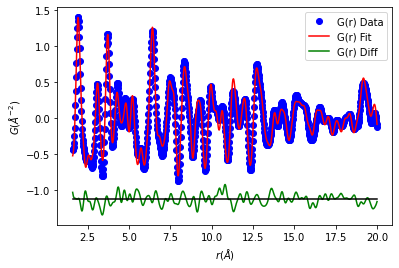

In [ ]:
visualize_fits(recipe)

### Save the results in files

In the last section, we saw our fits and were satisfied with the fits. In this section, we will save the results from the `FitRecipe`. We create the tool below to export the optimized values of the parameters, the data of the fits and the refined crystal structure in the files in a directory.

In [ ]:
def save_results(
        recipe: FitRecipe,
        directory: str,
        file_stem: str,
        pg_names: typing.List[str] = None,
        fc_name: str = "PDF"
) -> None:
    """Save the parameters, fits and structures in the FitRecipe object.

    Parameters
    ----------
    recipe :
        The FitRecipe object.
    directory :
        The directory to output the files.
    file_stem :
        The stem of the filename.
    pg_names :
        The name of the PDFGenerators (it will also be the name of the structures) to save. If None, not to save.
    fc_name
        The name of the FitContribution in the FitRecipe. Default "PDF".
    Returns
    -------
    None.
    """
    d_path = Path(directory)
    d_path.mkdir(parents=True, exist_ok=True)
    f_path = d_path.joinpath(file_stem)
    fr = FitResults(recipe)
    fr.saveResults(str(f_path.with_suffix(".res")))
    fc: FitContribution = getattr(recipe, fc_name)
    profile: Profile = fc.profile
    profile.savetxt(str(f_path.with_suffix(".fgr")))
    if pg_names is not None:
        for pg_name in pg_names:
            pg: PDFGenerator = getattr(fc, pg_name)
            stru: Crystal = pg.stru
            cif_path = f_path.with_name(
                "{}_{}".format(f_path.stem, pg_name)
            ).with_suffix(".cif")
            with cif_path.open("w") as f:
                stru.CIFOutput(f)
    return

We save the results in a folder "data/bronze".

In [ ]:
save_results(recipe, "data/bronze", "bronze", ["bronze"])

Here, we show what files are saved.

In [ ]:
!ls "./data/bronze"

bronze_bronze.cif  bronze.fgr  bronze.res


The "bronze.res" is a file of optimized parameters.

In [ ]:
!cat "./data/bronze/bronze.res"

Results written: Tue Aug 10 23:41:07 2021
produced by root

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       4.92082995
Contributions  4.92082995
Restraints     0.00000000
Chi2           4.92082995
Reduced Chi2   0.00549200
Rw             0.18819447

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
bronze_O2_Biso   6.18817791e-01 +/- 1.12967662e+00
bronze_O2_x      6.24352739e-02 +/- 8.17467582e-03
bronze_O2_z      3.63822660e-01 +/- 1.35605493e-02
bronze_O3_Biso   1.38824269e+00 +/- 1.79933126e+00
bronze_O3_x      1.21549191e-01 +/- 1.26787249e-02
bronze_O3_z      1.30173670e-02 +/- 1.25007735e-02
bronze_O4_Biso   8.27185985e-01 +/- 1.15721287e+00
bronze_O4_x      1.27399049e-01 +/- 9.19659753e-03
bronze_O4_z      7.14350739e-01 +/- 1.70952756e-02
bronze_O5_Biso   1.38273566e+00 +

The "bronze.fgr" is a four-column data file.

In [ ]:
!head -10 "./data/bronze/bronze.fgr"

# x  ycalc  y  dy
1.600000000000000089e+00 -5.219846152805963646e-01 -4.302509999999999946e-01 1.000000000000000000e+00
1.620000000000000107e+00 -5.035747442907761995e-01 -4.398569999999999980e-01 1.000000000000000000e+00
1.640000000000000124e+00 -4.730028530103902451e-01 -4.308619999999997452e-01 1.000000000000000000e+00
1.660000000000000142e+00 -4.256887546529156130e-01 -3.985039999999994698e-01 1.000000000000000000e+00
1.680000000000000160e+00 -3.571377434604373624e-01 -3.391249999999991216e-01 1.000000000000000000e+00
1.700000000000000178e+00 -2.636643841700392898e-01 -2.499379999999987445e-01 1.000000000000000000e+00
1.720000000000000195e+00 -1.431410245830593841e-01 -1.309709999999984498e-01 1.000000000000000000e+00
1.740000000000000213e+00 4.345347010906458300e-03 1.571630000000183436e-02 1.000000000000000000e+00
1.760000000000000231e+00 1.760421521014823298e-01 1.861500000000020638e-01 1.000000000000000000e+00


The "bronze_bronze.cif" is a CIF file of the refined bronze phase structure.

In [ ]:
!cat "./data/bronze/bronze_bronze.cif"

data_Ti8_O16

_computing_structure_solution     'FOX http://objcryst.sourceforge.net'

_symmetry_space_group_name_H-M    'C 1 2/m 1'
_symmetry_space_group_name_Hall   '-C 2y'

_cell_length_a    12.21966
_cell_length_b     3.75232
_cell_length_c     6.47675
_cell_angle_alpha  90.000
_cell_angle_beta  107.241
_cell_angle_gamma  90.000
_cell_volume       283.63
loop_
    _atom_site_label
    _atom_site_type_symbol
    _atom_site_fract_x
    _atom_site_fract_y
    _atom_site_fract_z
    _atom_site_U_iso_or_equiv
    _atom_site_occupancy
    _atom_site_adp_type
    Ti0        Ti        0.102453  0.000000  0.704901  0.005354 1.0000 Uiso
    Ti1        Ti        0.195686  0.000000  0.286421  0.009656 1.0000 Uiso
    O2         O         0.062435  0.000000  0.363823  0.007837 1.0000 Uiso
    O3         O         0.121549  0.000000  0.013017  0.017582 1.0000 Uiso
    O4         O         0.127399  0.500000  0.714351  0.010476 1.0000 Uiso
    O5         O         0.250801  0.500000  0.366861  0.

## Use PDFitc to find the secondary phase

There are still some residuals in the fits. It is likely that there is a secondary phase in the sample that produces a smaller PDF signal and it is hidden in the residuals. We would like to find what this phase could be and thus we output the residuals in a data file alone and submit it to the PDFitc.

In [ ]:
def export_diff_from_fgr(fgr_file: str, dst_file: str) -> None:
    """Export the difference curve in another file from a file containing x, ycalc, y, dy.

    Parameters
    ----------
    fgr_file :
        The input file containing four columns x, ycalc, y, dy.
    dst_file :
        The output file containing two columns x, y.

    Returns
    -------
    None.s
    """
    x, ycalc, y, _ = loadData(fgr_file).T
    diff = y - ycalc
    data = np.column_stack([x, diff])
    np.savetxt(dst_file, data, header="x y")
    return

In [ ]:
export_diff_from_fgr("./data/bronze/bronze.fgr", "./data/TiO2_residuals.gr")

We find the secondary phase may be the anatase phase (space group: "$I4_1amd$")

In [ ]:
df = pd.read_csv("./data/pdfitc_search_residuals.csv")
df[["rw", "formula", "space_group", "db", "db_id"]].head(10)

,rw,formula,space_group,db,db_id
0,0.908852,TiO2,I4_1/amd,COD,7206075
1,0.909445,TiO2,I4_1/amd,COD,1526931
2,0.909840,TiO2,I4_1/amd,COD,9008213
3,0.909858,TiO2,I4_1/amd,COD,9015929
4,0.909933,TiO2,I4_1/amd,COD,9008214
5,0.909990,TiO2,I4_1/amd,COD,9008215
6,0.910077,TiO2,I4_1/amd,COD,9008216
7,0.910508,TiO2,I4_1/amd,COD,9009086
8,0.914066,TiO2,I4_1/amd,MPD,mp-390
9,0.916685,TiO2,I4_1/amd,COD,1010942


## Fit the data with the bronze phase and anatase phase

We found that the secondary phase might be an anatase phase in the last section. We download its CIF file from the database and use it in our next fitting.

In [ ]:
CIF_FILE_A = "./data/TiO2_anatase.cif"

We create a model of mixture of bronze and anatase phase. The PDF is the linear combination of two PDFs.

In [ ]:
recipe = create_recipe_from_files(
    "sphere1 * bronze + sphere2 * anatase",
    cif_files={"bronze": CIF_FILE_B, "anatase": CIF_FILE_A},
    functions={
        "sphere1": (F.sphericalCF, ["r", "bronze_size"]),
        "sphere2": (F.sphericalCF, ["r", "anatase_size"])
    },
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

Since we have refined the bronze phase, we can use `initializeRecipe` to load the refined parameter values in the recipe for the bronze phase so that we can have a better starting point in the parameter space.

In [ ]:
from diffpy.srfit.fitbase.fitresults import initializeRecipe

initializeRecipe(recipe, "./data/bronze/bronze.res")

We refined the parameters. This time, we use the tag "scale", "lat", "adp", "delta2" and "xyz" without specifying the name of the phases. It means the free the parameters in that catalog in all phases. It can save us from tedious typing.

In [ ]:
optimize_params(
    recipe,
    [
        ["scale", "lat"], 
        ["adp", "delta2"], 
        ["xyz"], 
        ["bronze_size", "anatase_size"]
    ],
    rmin=1.6,
    rmax=20.0,
    rstep=0.02,
    ftol=1e-4
)

The fits look better.

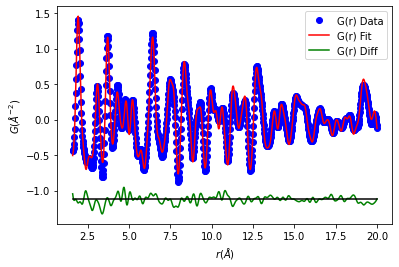

In [ ]:
visualize_fits(recipe)

We save the results in another folder.

In [ ]:
save_results(recipe, "./data/bronze_anatase", "two_phase", ["bronze", "anatase"])

## Fit the data with bronze, anatase and ligand

We know that the sample contains ligands. These ligands will produce a low frequency signal in the PDF because the standard deviation of the inter-molecular distances is much larger than the distances of atoms in a crystalline nanoparticle. The slow varying trend in the residuals from our last fit look like the signal from the ligands. We would like to include the PDF of the ligand in our model so that we can have a more accurate fits but at the same time, we don't want to deal with the complicated simulation of a bunch of molecules. Thus, we decide to use a analytic function to simulate the ligand PDF. It is a Gaussian damping sinusoidal wave defined in the function below.

In [ ]:
def ligand_pdf(r: np.ndarray, a: float, s: float, k: float, r0: float) -> np.ndarray:
    """The Gaussian damping cosine function. Simulate the PDF of the ligand.
    
    Parameters
    ----------
    r :
        The array of r.
    a :
        The amplitude of the function.
    s :
        The decay rate.
    k :
        The wave vector.
    r0 :
        The zero phase r value.

    Returns
    -------
    A data array of function values.
    """
    return a * np.exp(-np.square(s * r)) * np.cos(k * (r - r0))

We add this function into our model.

In [ ]:
recipe = create_recipe_from_files(
    "sphere1 * bronze + sphere2 * anatase + ligand",
    cif_files={"bronze": CIF_FILE_B, "anatase": CIF_FILE_A},
    functions={
        "sphere1": (F.sphericalCF, ["r", "bronze_size"]),
        "sphere2": (F.sphericalCF, ["r", "anatase_size"]),
        "ligand": (ligand_pdf, ["r", "ligand_a", "ligand_s", "ligand_k", "ligand_r0"])
    },
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

Like last time, we will use the parameter values from the two phase fit in the last section as the starting point.

In [ ]:
initializeRecipe(recipe, "./data/bronze_anatase/two_phase.res")

We set the parameters in our analytic function to be a reasonable value. Below shows the way to do that. All the parameters in the FitRecipe can be set in this way.

In [ ]:
# set the values for the ligand PDF parameters
recipe.ligand_a.setValue(-0.01)
recipe.ligand_s.setValue(0.1)
recipe.ligand_k.setValue(1.5)
recipe.ligand_r0.setValue(3.5);

Here is the starting point of our fitting.

We refine the FitRecipe starting from the ligand because the parameters in the bronze and anatase are loaded from the last refinement and there probably won't be large changes in them.

In [ ]:
optimize_params(
    recipe,
    [
        ["ligand"],
        ["scale", "lat"], 
        ["adp", "delta2"], 
        ["xyz"], 
        ["bronze_size", "anatase_size"]
    ],
    rmin=1.6,
    rmax=20.0,
    rstep=0.02,
    ftol=1e-4
)

Now, our fits look even better.

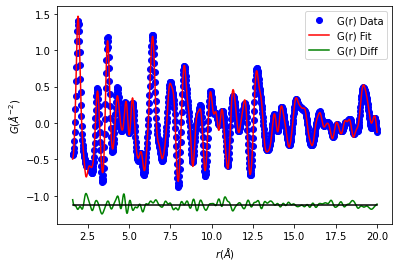

In [ ]:
visualize_fits(recipe)

We save the results in another folder.

In [ ]:
save_results(recipe, "./data/bronze_anatase_ligand", "three_phase", ["bronze", "anatase"])

## Fit the data up to 50 Å

We have achieved a good fit and we think that the bronze, anatase, ligand mixture is our answer for what are inside our samples. We need to finally confirm it and obtain the structure parameters from the fitting of the whole range of PDF.

In [ ]:
recipe = create_recipe_from_files(
    "sphere1 * bronze + sphere2 * anatase + ligand",
    cif_files={"bronze": CIF_FILE_B, "anatase": CIF_FILE_A},
    functions={
        "sphere1": (F.sphericalCF, ["r", "bronze_size"]),
        "sphere2": (F.sphericalCF, ["r", "anatase_size"]),
        "ligand": (ligand_pdf, ["r", "ligand_a", "ligand_s", "ligand_k", "ligand_r0"])
    },
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

In [ ]:
initializeRecipe(recipe, "./data/bronze_anatase_ligand/three_phase.res")

In [ ]:
optimize_params(
    recipe,
    [
        ["scale", "bronze_size", "anatase_size"], 
        ["lat"], 
        ["adp", "delta2"], 
        ["xyz"],
        ["ligand"],
    ],
    rmin=1.6,
    rmax=50.0,
    rstep=0.02,
    ftol=1e-4
)

The fits look good. However, if we look carefully at the high-$r$ range. The calculated PDF is over-damped. It is likely that the spherical characteristic function doesn't represent the real case of particle size.

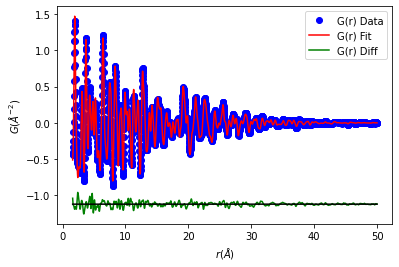

In [ ]:
visualize_fits(recipe)

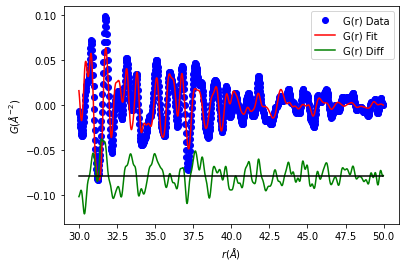

In [ ]:
visualize_fits(recipe, xlim=(30, 50))

We save the results in another folder.

In [ ]:
save_results(recipe, "./data/bronze_anatase_ligand_50A", "three_phase_50A", ["bronze", "anatase"])

## Fit the data with a core-shell model

Maybe the nanoparticle has a core-shell structure where the bronze phase core is wrapped in the anatase phase shell. In this section, we will try the core-shell model.

In [ ]:
recipe = create_recipe_from_files(
    "core * bronze + shell * anatase + ligand",
    cif_files={"bronze": CIF_FILE_B, "anatase": CIF_FILE_A},
    functions={
        "core": (F.sphericalCF, ["r", "bronze_diameter"]),
        "shell": (F.shellCF, ["r", "bronze_radius", "anatase_thickness"]),
        "ligand": (ligand_pdf, ["r", "ligand_a", "ligand_s", "ligand_k", "ligand_r0"])
    },
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

In [ ]:
initializeRecipe(recipe, "./data/bronze_anatase_ligand_50A/three_phase_50A.res")

In [ ]:
recipe.bronze_diameter.setValue(40.)
recipe.bronze_radius.setValue(20.)
recipe.anatase_thickness.setValue(20.);

Here, we constrain the "bronze_diameter" by the "2 * bronze_radius" so that the diameter of the bronze phase in the spherical characteristic function will always be determined by the double of inner radius in the shell characteristic function.

In [ ]:
recipe.constrain("bronze_diameter", "2 * bronze_radius")

In [ ]:
optimize_params(
    recipe,
    [
        ["scale", "core", "shell"], 
        ["lat"], 
        ["adp", "delta2"], 
        ["xyz"],
        ["ligand"],
    ],
    rmin=1.6,
    rmax=50.0,
    rstep=0.02,
    ftol=1e-4
)

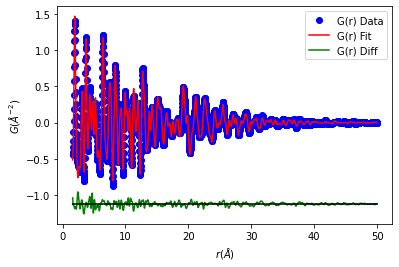

In [ ]:
visualize_fits(recipe)

In [ ]:
save_results(recipe, "./data/bronze_anatase_ligand_50A_coreshell", "three_phase_50A_coreshell", ["bronze", "anatase"])

Let's compare the results from the two fits.

In [ ]:
def visualize_grs_from_files(
        fgr_files: typing.List[str],
        xlim: typing.Tuple = None,
        ax: plt.Axes = None,
        labels: typing.List[str] = None
) -> None:
    """Visualize the G(r) in multiple files.

    Parameters
    ----------
    fgr_files :
        A list of files containing the r, g data.
    xlim :
        The boundary of the x to show in the plot.
    ax :
        The Axes to show the plot.
    labels :
        The lables of the curves.

    Returns
    -------
    None.
    """
    if labels is None:
        labels = []
    if ax is None:
        _, ax = plt.subplots()
    for fgr_file in fgr_files:
        r, g = loadData(fgr_file).T[:2]
        if xlim is not None:
            sel = np.logical_and(r >= xlim[0], r <= xlim[1])
            r = r[sel]
            g = g[sel]
        # plot figure
        ax.plot(r, g, '-')
    ax.set_xlabel(r"$r (\AA)$")
    ax.set_ylabel(r"$G (\AA^{-2})$")
    if labels is not None:
        ax.legend(labels, loc=1)
    return

It seems that there is no improvement to the fits at the high-$r$.

In [ ]:
SPHERICAL_FILE = "./data/bronze_anatase_ligand_50A/three_phase_50A.fgr"
CORESHELL_FILE = "./data/bronze_anatase_ligand_50A_coreshell/three_phase_50A_coreshell.fgr"

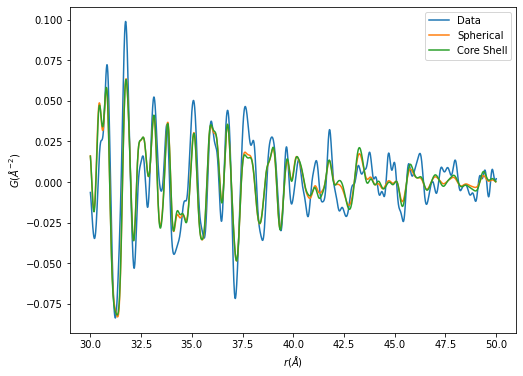

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
visualize_grs_from_files(
    [GR_FILE, SPHERICAL_FILE, CORESHELL_FILE],
    xlim=(30, 50),
    ax=ax,
    labels=["Data", "Spherical", "Core Shell"]
)
plt.show()

## Use a spheroidal characteristic function

Maybe the particle shape is not a sphere but a spheroid. We will test this possibility by using the spheroidal characteristic function.

In [ ]:
recipe = create_recipe_from_files(
    "spheroidal * bronze + sphere * anatase + ligand",
    cif_files={"bronze": CIF_FILE_B, "anatase": CIF_FILE_A},
    functions={
        "spheroidal": (F.spheroidalCF, ["r", "bronze_erad", "bronze_prad"]),
        "sphere": (F.sphericalCF, ["r", "anatase_size"]),
        "ligand": (ligand_pdf, ["r", "ligand_a", "ligand_s", "ligand_k", "ligand_r0"])
    },
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

In [ ]:
initializeRecipe(recipe, "./data/bronze_anatase_ligand_50A/three_phase_50A.res")

In [ ]:
recipe.bronze_erad.setValue(40.0)
recipe.bronze_prad.setValue(40.0);

In [ ]:
optimize_params(
    recipe,
    [
        ["scale", "spheroidal", "sphere"], 
        ["lat"], 
        ["adp", "delta2"], 
        ["xyz"],
        ["ligand"],
    ],
    rmin=1.6,
    rmax=50.0,
    rstep=0.02,
    ftol=1e-4
)

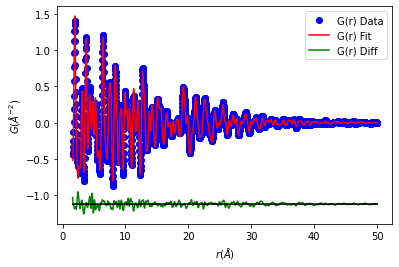

In [ ]:
visualize_fits(recipe)

In [ ]:
save_results(recipe, "./data/bronze_anatase_ligand_50A_spheroidal", "three_phase_50A_spheroidal", ["bronze", "anatase"])

There is a improvement of the quality of the fits at the high-$r$. Maybe the shape of the particle is a spheroid.

In [ ]:
SPHEROIDAL_FILE = "./data/bronze_anatase_ligand_50A_spheroidal/three_phase_50A_spheroidal.fgr"

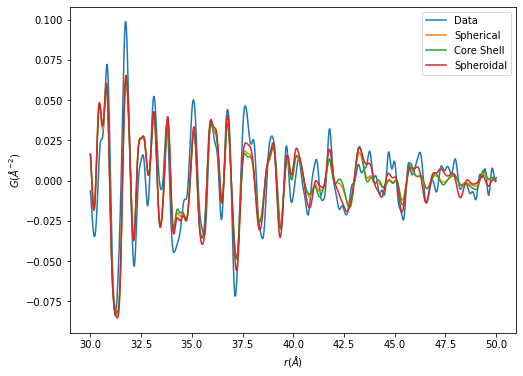

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
visualize_grs_from_files(
    [GR_FILE, SPHERICAL_FILE, CORESHELL_FILE, SPHEROIDAL_FILE],
    xlim=(30, 50),
    ax=ax,
    labels=["Data", "Spherical", "Core Shell", "Spheroidal"]
)
plt.show()

## Use a lognormal spherical characteristic function

Maybe the particle sizes of the bronze phase nanoparticles are not uniform. They have a distribution. It is likely to be approximated by a lognormal distribution. In this section, we will try the lognormal distribution.

In [ ]:
recipe = create_recipe_from_files(
    "lognormal * bronze + sphere * anatase + ligand",
    cif_files={"bronze": CIF_FILE_B, "anatase": CIF_FILE_A},
    functions={
        "lognormal": (F.lognormalSphericalCF, ["r", "bronze_size_mean", "bronze_size_std"]),
        "sphere": (F.sphericalCF, ["r", "anatase_size"]),
        "ligand": (ligand_pdf, ["r", "ligand_a", "ligand_s", "ligand_k", "ligand_r0"])
    },
    data_file=GR_FILE,
    meta_data={"qdamp": 0.04, "qbroad": 0.02}
)

In [ ]:
initializeRecipe(recipe, "./data/bronze_anatase_ligand_50A/three_phase_50A.res")

In [ ]:
recipe.bronze_size_mean.setValue(40.0)
recipe.bronze_size_std.setValue(5.0);

In [ ]:
optimize_params(
    recipe,
    [
        ["scale", "sphere", "lognormal"], 
        ["lat"], 
        ["adp", "delta2"], 
        ["xyz"],
        ["ligand"],
    ],
    rmin=1.6,
    rmax=50.0,
    rstep=0.02,
    ftol=1e-4
)

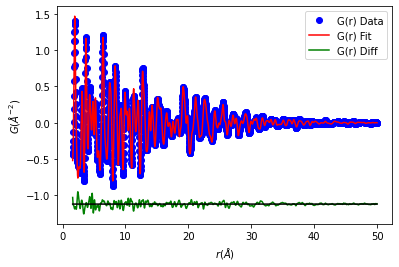

In [ ]:
visualize_fits(recipe)

In [ ]:
save_results(recipe, "./data/bronze_anatase_ligand_50A_lognormal", "three_phase_50A_lognormal", ["bronze", "anatase"])

The lognormal spherical distribution function improve the quality of fits at the high-$r$ is slightly better than the spheroid characteristic function. May the size of the particles are not the same value but follows a distribution.

In [ ]:
LOGNORMAL_FILE = "./data/bronze_anatase_ligand_50A_lognormal/three_phase_50A_lognormal.fgr"

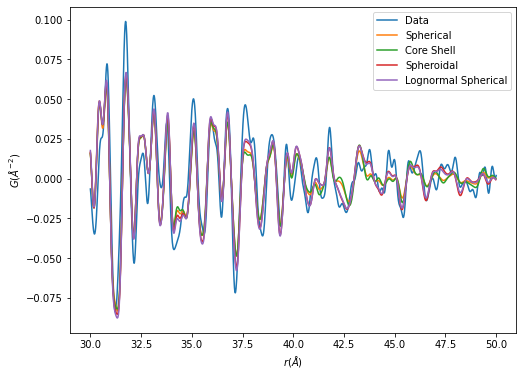

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
visualize_grs_from_files(
    [GR_FILE, SPHERICAL_FILE, CORESHELL_FILE, SPHEROIDAL_FILE, LOGNORMAL_FILE],
    xlim=(30, 50),
    ax=ax,
    labels=["Data", "Spherical", "Core Shell", "Spheroidal", "Lognormal Spherical"]
)
plt.show()

## Particle size

Below shows the TEM image of the sample taken before the ligand was added. The particles are not in the same size while at the same time not perfectly spherical.

![TEM](https://github.com/st3107/20210818_iucr_diffpy_talk/blob/main/notebooks/data/tem.png?raw=1)

The TEM results show that the particles size in average is 75 Å while result from the PDF fitting using the spherical characteristic function is 50 Å. This is normal because the particle size in the characteristic function is the size of the domain of structural order, which cannot be larger than the physical size of the particle but in general is smaller due to disorder. This value thus may be smaller than what we saw in the TEM.

## Summary

We reveals that the sample consists of bronze TiO2 nanoparticles and anatase TiO2 nanoparticles and ligands. The bronze TiO2 nanoparticle is the majority as our collaborators expect and the anatase an impurity phase. Its proportion is about 9 %.

In [ ]:
3.56452857e-02 / (3.44354912e-01 + 3.56452857e-02) * 100

9.380333461863353

The particle size of bronze phase is about 50 Å while the particle size of anatase phase is about 70 Å. The structure parameters of them are shown below.

In [ ]:
!cat "./data/bronze_anatase_ligand_50A/three_phase_50A.res"

Results written: Tue Aug 10 23:45:52 2021
produced by root

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       2.29703817
Contributions  2.29703817
Restraints     0.00000000
Chi2           2.29703817
Reduced Chi2   0.00096352
Rw             0.12333562

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
anatase_O1_Biso   1.44082854e+00 +/- 3.15810793e+00
anatase_O1_z      2.20066411e-01 +/- 2.80619252e-02
anatase_Ti1_Biso  4.34184391e-01 +/- 7.31492330e-01
anatase_a         3.78702154e+00 +/- 2.79746547e-02
anatase_c         9.50083752e+00 +/- 1.14366001e-01
anatase_delta2    2.65149833e-07 +/- 5.34773077e+00
anatase_scale     3.56452857e-02 +/- 3.60289750e-02
anatase_size      7.77729417e+01 +/- 1.47524395e+02
bronze_O2_Biso    9.75116829e-01 +/- 1.48880179e+00
bronze_O2_x       6.3108

In this tutorial, we have introduced an universal way to build models to fit the PDF data using diffpy-cmi. The users can not only use any characteristic functions and structures in their models but also define their own calculators as python functions and refine the parameters in it. It offers the users the freedom to create and refine models beyond the traditional ways of multi-phase modeling where the PDF can only be calculated by the structures and a limited number of predefined characteristic functions.